In [12]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import klib

In [13]:
test= pd.read_csv("test.csv")
dataset= pd.read_csv("train.csv")
df= pd.concat([dataset,test], axis=0).reset_index()
df.loc[(df['Item_Fat_Content']=='LF') | (df['Item_Fat_Content']=='low fat') | (df['Item_Fat_Content']=='LOW'),'Item_Fat_Content']='Low Fat'
df.loc[(df['Item_Fat_Content']=='reg'),'Item_Fat_Content']='Regular'
df.Item_Fat_Content.unique()
df["Item_Weight"]=df[["Item_Weight"]].fillna(df["Item_Weight"].mean())
mode_val=df[["Outlet_Size","Outlet_Type"]].pivot_table(index='Outlet_Type', aggfunc=(lambda x: x.mode()))
missing=df["Outlet_Size"].isnull()
df.loc[missing, "Outlet_Size"]=df.loc[missing, "Outlet_Type"].apply(lambda x: mode_val.loc[x])
df=klib.convert_datatypes(df)
df

,index,Item_Identifier,Item_Weight,Item_Fat_Content,Item_Visibility,Item_Type,Item_MRP,Outlet_Identifier,Outlet_Establishment_Year,Outlet_Size,Outlet_Location_Type,Outlet_Type,Item_Outlet_Sales
0,0,FDA15,9.300000,Low Fat,0.016047,Dairy,249.809204,OUT049,1999,Medium,Tier 1,Supermarket Type1,3735.137939
1,1,DRC01,5.920000,Regular,0.019278,Soft Drinks,48.269199,OUT018,2009,Medium,Tier 3,Supermarket Type2,443.422791
2,2,FDN15,17.500000,Low Fat,0.016760,Meat,141.617996,OUT049,1999,Medium,Tier 1,Supermarket Type1,2097.270020
3,3,FDX07,19.200001,Regular,0.000000,Fruits and Vegetables,182.095001,OUT010,1998,Small,Tier 3,Grocery Store,732.380005
4,4,NCD19,8.930000,Low Fat,0.000000,Household,53.861401,OUT013,1987,High,Tier 3,Supermarket Type1,994.705200
...,...,...,...,...,...,...,...,...,...,...,...,...,...
14199,5676,FDB58,10.500000,Regular,0.013496,Snack Foods,141.315399,OUT046,1997,Small,Tier 1,Supermarket Type1,NaN
14200,5677,FDD47,7.600000,Regular,0.142991,Starchy Foods,169.144806,OUT018,2009,Medium,Tier 3,Supermarket Type2,NaN
14201,5678,NCO17,10.000000,Low Fat,0.073529,Health and Hygiene,118.744003,OUT045,2002,Small,Tier 2,Supermarket Type1,NaN
14202,5679,FDJ26,15.300000,Regular,0.000000,Canned,214.621796,OUT017,2007,Small,Tier 2,Supermarket Type1,NaN


***
# 3. DATA PREPROCESSING FOR MODEL
***
## i) Encoding
~ Will one hot encoding give better accuracy?

For ordinal variables, no.

Example: for a data
- a > b > c > d

For x => a (real), Its better that the model predicts:
- x => b (predicted ordinally) 
- than 
- x => d (predicted nominally)

#### One Hot Encoder
- Creates alot of categories
- Only used for two nominal columns

! Take only top 10 categories if model efficiency is compromised because of columns

In [14]:
from sklearn.preprocessing import OneHotEncoder
oneHot= OneHotEncoder()

x=oneHot.fit_transform(df[["Item_Type","Outlet_Identifier"]]).toarray()
y=oneHot.get_feature_names_out()
df1=pd.concat([df,pd.DataFrame(x, columns=y)], axis=1)
# pd.DataFrame(x, columns=y).size

In [15]:
df1=df1.drop(columns=["Item_Type", "Outlet_Identifier", "index", "Item_Identifier"])
df1.tail(2)

,Item_Weight,Item_Fat_Content,Item_Visibility,Item_MRP,Outlet_Establishment_Year,Outlet_Size,Outlet_Location_Type,Outlet_Type,Item_Outlet_Sales,Item_Type_Baking Goods,...,Outlet_Identifier_OUT010,Outlet_Identifier_OUT013,Outlet_Identifier_OUT017,Outlet_Identifier_OUT018,Outlet_Identifier_OUT019,Outlet_Identifier_OUT027,Outlet_Identifier_OUT035,Outlet_Identifier_OUT045,Outlet_Identifier_OUT046,Outlet_Identifier_OUT049
14202,15.3,Regular,0.00000,214.621796,2007,Small,Tier 2,Supermarket Type1,NaN,0.0,...,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
14203,9.5,Regular,0.10472,79.795998,2002,Small,Tier 2,Supermarket Type1,NaN,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0


#### Label Encoder
- Easier to implement 
- but should be used only for target variable

Label encoder has encoded Outlet Size as
- High>Medium>Small (Alphabetically)
- 0, 1, 2
- Changing the order through ordinal encoder
 
==> Its better to use ordinal encoder for dependant variables

In [16]:
# from sklearn.preprocessing import LabelEncoder
# labelencoder= LabelEncoder()

# df1[["Item_Fat_Content", "Outlet_Size", "Outlet_Location_Type", "Outlet_Type"]]=df[["Item_Fat_Content",
#     "Outlet_Size", "Outlet_Location_Type", "Outlet_Type"]].apply(labelencoder.fit_transform)
# df1.iloc[:,:15]

#### Ordinal Encoder
- Same as label encoder
- But we can specify order

Eg- Cold, hot, warm
- Label Encoder => 0,1,2 (alphabetically)
- Ordinal Encoder => 0,1,2 (alphabetically)
- But we have option to give cold>warm>hot 
- Hence: Cold, hot, warm => 0,2,1

In [17]:
from sklearn.preprocessing import OrdinalEncoder

outlet_size_encoder= OrdinalEncoder(categories=[["Small","Medium", "High"]], dtype=np.str_)
ordencoder= OrdinalEncoder()

df1[["Item_Fat_Content", "Outlet_Location_Type", "Outlet_Type"]]=ordencoder.fit_transform(df1[["Item_Fat_Content", "Outlet_Location_Type", "Outlet_Type"]])
df1[["Outlet_Size"]]=outlet_size_encoder.fit_transform(df1[["Outlet_Size"]])
df1

,Item_Weight,Item_Fat_Content,Item_Visibility,Item_MRP,Outlet_Establishment_Year,Outlet_Size,Outlet_Location_Type,Outlet_Type,Item_Outlet_Sales,Item_Type_Baking Goods,...,Outlet_Identifier_OUT010,Outlet_Identifier_OUT013,Outlet_Identifier_OUT017,Outlet_Identifier_OUT018,Outlet_Identifier_OUT019,Outlet_Identifier_OUT027,Outlet_Identifier_OUT035,Outlet_Identifier_OUT045,Outlet_Identifier_OUT046,Outlet_Identifier_OUT049
0,9.300000,0.0,0.016047,249.809204,1999,1,0.0,1.0,3735.137939,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0
1,5.920000,1.0,0.019278,48.269199,2009,1,2.0,2.0,443.422791,0.0,...,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0
2,17.500000,0.0,0.016760,141.617996,1999,1,0.0,1.0,2097.270020,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0
3,19.200001,1.0,0.000000,182.095001,1998,0,2.0,0.0,732.380005,0.0,...,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,8.930000,0.0,0.000000,53.861401,1987,2,2.0,1.0,994.705200,0.0,...,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
14199,10.500000,1.0,0.013496,141.315399,1997,0,0.0,1.0,NaN,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0
14200,7.600000,1.0,0.142991,169.144806,2009,1,2.0,2.0,NaN,0.0,...,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0
14201,10.000000,0.0,0.073529,118.744003,2002,0,1.0,1.0,NaN,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0
14202,15.300000,1.0,0.000000,214.621796,2007,0,1.0,1.0,NaN,0.0,...,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


## ii) Train Test Split

leave categorical

In [166]:
train_data=df1.iloc[:8523]
test_data=df1.iloc[8523:]
y=train_data[["Item_Outlet_Sales"]]
x=train_data.drop(columns="Item_Outlet_Sales")

In [167]:
from sklearn.model_selection import train_test_split

In [168]:
x_train, x_test, y_train, y_test = train_test_split(x, y, test_size = 0.30)

## iii) Standardization
#### Does not make much difference here

fit_transform() ==> Train data 

transform() ==>Test data
- so that params are not computed again
- overfitting is avoided

In [20]:
from sklearn.preprocessing import StandardScaler

scaler= StandardScaler()
x_train=scaler.fit_transform(x_train)
x_test=scaler.transform(x_test)

C:\Users\LENOVO\AppData\Local\Temp\ipykernel_74168\4043636264.py:2: UserWarning: 

`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `histplot` (an axes-level function for histograms).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed2974457ad6372750bbe5751

  sns.distplot(x, label="s")


<Axes: ylabel='Density'>

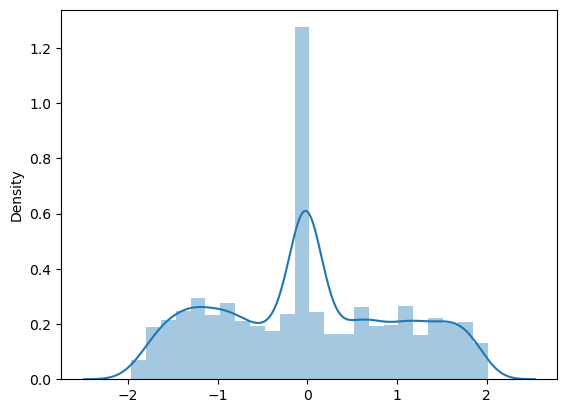

In [27]:
x=[x_train[i][0] for i in range(len(x_train))]
sns.distplot(x, label="s")

***
# 4) APPLYING ML MODELS
***

# Linear Models

## Linear Regression:

feature names variable

In [28]:
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import cross_val_score

model.fit() ==> Train data

model.predict() ==> Test data

In [169]:
linear_reg= LinearRegression()

linear_reg.fit(x_train, y_train)
y_pred=linear_reg.predict(x_test)

In [170]:
# sns.scatterplot(data=x, x=x.Item_MRP, y=y_train, color='blue')
 
# plt.plot(x_test, y_pred, color='red')
# plt

C:\Users\LENOVO\AppData\Local\Temp\ipykernel_74168\3524681940.py:1: UserWarning: 

`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `histplot` (an axes-level function for histograms).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed2974457ad6372750bbe5751

  sns.distplot(y_pred-y_test)


<Axes: ylabel='Density'>

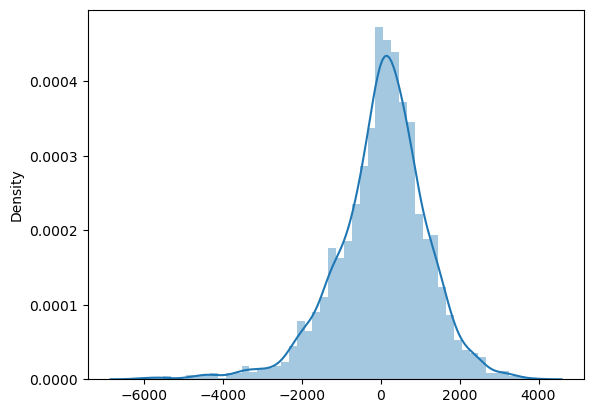

In [171]:
sns.distplot(y_pred-y_test)

diff b/w score and r2, params diff

In [172]:
linear_reg.score(x_test,y_test)

0.540191354241513

In [174]:
from sklearn.metrics import r2_score, mean_absolute_error, mean_squared_error
print(r2_score(y_test,y_pred))
print(mean_absolute_error(y_test,y_pred))
print(mean_squared_error(y_test,y_pred, squared=False))

0.540191354241513
857.9880777469702
1157.9070809473772


In [175]:
np.mean(cross_val_score(linear_reg, x_train, y_train, scoring='r2', cv=5))

0.5691770058385274

In [53]:
linear_reg.coef_
# linear_reg.intercept_

array([[-1.34870407e+01,  3.17804281e+01, -3.16136618e+01,
         9.64468584e+02,  9.15174947e+13, -1.59866254e+14,
         2.60862873e+14, -1.70943922e+14, -3.00955443e+13,
        -1.93892067e+13, -1.32165881e+13, -3.03136963e+13,
        -3.10755388e+13, -3.48641537e+13, -4.05351176e+13,
        -1.88433293e+13, -2.76792979e+13, -3.56813042e+13,
        -2.45482997e+13, -1.59995924e+13, -9.26006425e+12,
        -3.95848042e+13, -2.58122069e+13, -1.50384754e+13,
        -2.39204122e+14, -5.07560098e+13, -1.63185503e+14,
        -1.30104236e+14, -4.36005675e+13,  1.83294077e+13,
        -1.53187151e+14, -1.45581855e+14, -2.91243704e+13,
         3.64810031e+13]])

In [155]:
df1.columns

Index(['Item_Weight', 'Item_Fat_Content', 'Item_Visibility', 'Item_MRP',
       'Outlet_Establishment_Year', 'Outlet_Size', 'Outlet_Location_Type',
       'Outlet_Type', 'Item_Outlet_Sales', 'Item_Type_Baking Goods',
       'Item_Type_Breads', 'Item_Type_Breakfast', 'Item_Type_Canned',
       'Item_Type_Dairy', 'Item_Type_Frozen Foods',
       'Item_Type_Fruits and Vegetables', 'Item_Type_Hard Drinks',
       'Item_Type_Health and Hygiene', 'Item_Type_Household', 'Item_Type_Meat',
       'Item_Type_Others', 'Item_Type_Seafood', 'Item_Type_Snack Foods',
       'Item_Type_Soft Drinks', 'Item_Type_Starchy Foods',
       'Outlet_Identifier_OUT010', 'Outlet_Identifier_OUT013',
       'Outlet_Identifier_OUT017', 'Outlet_Identifier_OUT018',
       'Outlet_Identifier_OUT019', 'Outlet_Identifier_OUT027',
       'Outlet_Identifier_OUT035', 'Outlet_Identifier_OUT045',
       'Outlet_Identifier_OUT046', 'Outlet_Identifier_OUT049'],
      dtype='object')

## Polynomial Regression:

In [ ]:
from sklearn.preprocessing import PolynomialFeatures

In [176]:
polynomial_features= PolynomialFeatures(degree=2)

x_poly = polynomial_features.fit_transform(x_train)
x_poly_test =  polynomial_features.transform(x_test)

model = LinearRegression()
polynomial_features.fit(x_poly, y_train)
model.fit(x_poly, y_train)

LinearRegression()

In [177]:
y_poly_pred = model.predict(x_poly_test)

In [178]:
print(r2_score(y_test,y_poly_pred))
print(mean_absolute_error(y_test,y_poly_pred))
print(mean_squared_error(y_test,y_poly_pred, squared=False))

0.5693422653601079
786.9952026041962
1120.6016795636529


In [68]:
print(r2_score(y_test,y_pred))
print(mean_absolute_error(y_test,y_pred))
print(mean_squared_error(y_test,y_pred, squared=False))

0.5635134153465564
832.071973067482
1113.3946395147648


In [58]:
model.coef_
# model.intercept_

array([[-1.36435105e+10, -1.57733555e+01,  3.21283350e+01,
        -3.40594474e+01,  9.65863873e+02, -7.47086838e+14,
        -1.16653299e+15, -3.06048991e+15, -3.80656556e+14,
        -6.74795715e+14, -4.34740553e+14, -2.96339449e+14,
        -6.79687071e+14, -6.96768938e+14, -7.81716432e+14,
        -9.08869546e+14, -4.22501010e+14, -6.20619166e+14,
        -8.00038401e+14, -5.50416610e+14, -3.58739363e+14,
        -2.07627136e+14, -8.87561826e+14, -5.78755659e+14,
        -3.37189408e+14,  1.06385502e+15,  2.26362370e+15,
         5.59934213e+14,  2.46197742e+15, -1.07611310e+15,
         1.93370859e+15,  4.77270990e+14,  4.19374182e+14,
        -8.83949126e+14, -3.06105941e+14]])

##### Result
- Similar to linear reg, polynomial of degree 2 fits well 
- Performs just slightly better

## Ridge Regression:

In [78]:
from sklearn.linear_model import Ridge
from sklearn.model_selection import GridSearchCV

In [183]:
ridge_reg =  Ridge(alpha=35)

In [184]:
## Hyperparameter tuning

parameters={'alpha':[x for x in range(35,45)]}
ridgecv =GridSearchCV(ridge_reg, parameters, scoring="r2", cv=5)
ridgecv.fit(x_train,y_train)

GridSearchCV(cv=5, estimator=Ridge(alpha=35),
             param_grid={'alpha': [35, 36, 37, 38, 39, 40, 41, 42, 43, 44]},
             scoring='r2')

In [185]:
ridgecv.best_params_

{'alpha': 35}

In [186]:
ridgecv.best_score_

0.5692248339376835

In [187]:
ridge_reg.fit(x_train,y_train)
y_ridge_pred=ridge_reg.predict(x_test)

In [188]:
r2_score(y_test,y_ridge_pred)

0.5401648409264472

##### Result
- Doesn't do much

## Lasso Regression:

In [120]:
from sklearn.linear_model import Lasso

In [193]:
lasso_reg= Lasso(alpha=3)

In [194]:
parameters={'alpha':[x for x in range(1,25)]}
lassocv =GridSearchCV(lasso_reg, parameters, scoring="r2", cv=5)
lassocv.fit(x_train,y_train)

GridSearchCV(cv=5, estimator=Lasso(alpha=3),
             param_grid={'alpha': [1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13,
                                   14, 15, 16, 17, 18, 19, 20, 21, 22, 23,
                                   24]},
             scoring='r2')

In [195]:
print("Features seen:",lassocv.n_features_in_)
print(lassocv.best_params_)
print(lassocv.best_score_)

Features seen: 34
{'alpha': 3}
0.5702684763408594


In [197]:
lasso_reg.n_features_in_

34

In [196]:
lasso_reg.fit(x_train,y_train)
y_lasso_pred=lasso_reg.predict(x_test)
r2_score(y_test,y_lasso_pred)

0.5403024298686621

Removed features??

In [200]:
# from sklearn.feature_selection import SelectFromModel

In [201]:
# removed features
# sel_ = SelectFromModel(lasso)
# sel_.fit(scaler.transform(x_train), y_train)
# (sel_.estimator_.coef_ == 0).ravel().tolist()

##### Result
- Not much difference

***
#### Linear Model

- Linear Regression (deg=1)
- Polynomial Regression (deg=2)
- Ridge Regression (alpha=37)
- Lasso Regression (alpha=12)

#### Tree Model

- Decision Tree
- Random Forest
- XGBoost

***

# Tree Models